## Analyzing phage concentration titration

To figure out how much phage to add during our screen, I varied the amount of phage during the infection protocol. This ipython notebook segments that data and computes the fraction of cells that are infected (lytic + lysogenic) to infer the MOI.

In [1]:
#Import packages
import numpy as np 
import os
import tifffile as tiff
from skimage.io import imread
from skimage.measure import label, regionprops
import scipy
import matplotlib.pyplot as plt
import cPickle as pickle
from SLIP_functions import analyze_well, analyze_plate, segment_SLIP, plot_slip_well
from SLIP_functions import plot_slip_joint_plot, fit_kde, compute_p_values
import seaborn as sns
import pandas as pd

sns.set_context('notebook', font_scale = 1.1)
sns.set_style('white')
sns.set_style('ticks')

#Activate matplotlib inline
%matplotlib inline

#Define root directory path
root_direc = '/home/vanvalen/Data/keio_screen/07.03.2017/BW25113_phage_concentration_center/'

#Define directory path to infection data (all positions)
data_direc = os.path.join(root_direc, 'data')

#Define directory path to control data (all positions)
control_direc = os.path.join(root_direc, 'control')

#Define directory path to where you want to store neural net outputs. 
#mask directories must exist at run time!
mask_direc = os.path.join(root_direc, 'masks')
control_mask_direc = os.path.join(root_direc,'control_masks')

tifffile.py:156: UserWarning: failed to import the optional _tifffile C extension module.
Loading of some compressed images will be slow.
Tifffile.c can be obtained at http://www.lfd.uci.edu/~gohlke/
  "failed to import the optional _tifffile C extension module.\n"
Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5005)


In [2]:
#Define which wells were used
row = ['A']
col_control = [12]
col_data = [5,7,9,10,11]

In [12]:
#Segment the control wells
segment_SLIP(control_direc, control_mask_direc, alphabet = row, columns= col_control)

['A'] [12]
Segmenting Position A12


cnn_functions.py:255: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  pooled_array +=[pool_2d(input_image[:, :, offset_x::stride, offset_y::stride], pool_size, st = (1,1), mode = mode, padding = (0,0), ignore_border = True)]
cnn_functions.py:255: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  pooled_array +=[pool_2d(input_image[:, :, offset_x::stride, offset_y::stride], pool_size, st = (1,1), mode = mode, padding = (0,0), ignore_border = True)]


Processing image 1 of 9
Processing image 2 of 9
Processing image 3 of 9
Processing image 4 of 9
Processing image 5 of 9
Processing image 6 of 9
Processing image 7 of 9
Processing image 8 of 9
Processing image 9 of 9
Processing image 1 of 9
Processing image 2 of 9
Processing image 3 of 9
Processing image 4 of 9
Processing image 5 of 9
Processing image 6 of 9
Processing image 7 of 9
Processing image 8 of 9
Processing image 9 of 9
Processing image 1 of 9
Processing image 2 of 9
Processing image 3 of 9
Processing image 4 of 9
Processing image 5 of 9
Processing image 6 of 9
Processing image 7 of 9
Processing image 8 of 9
Processing image 9 of 9


In [17]:
#Segment the infected wells
segment_SLIP(data_direc, mask_direc, alphabet = row, columns= col_data)

['A'] [9]
Segmenting Position A9
Processing image 1 of 9
Processing image 2 of 9
Processing image 3 of 9
Processing image 4 of 9
Processing image 5 of 9
Processing image 6 of 9
Processing image 7 of 9
Processing image 8 of 9
Processing image 9 of 9
Processing image 1 of 9
Processing image 2 of 9
Processing image 3 of 9
Processing image 4 of 9
Processing image 5 of 9
Processing image 6 of 9
Processing image 7 of 9
Processing image 8 of 9
Processing image 9 of 9
Processing image 1 of 9
Processing image 2 of 9
Processing image 3 of 9
Processing image 4 of 9
Processing image 5 of 9
Processing image 6 of 9
Processing image 7 of 9
Processing image 8 of 9
Processing image 9 of 9


In [3]:
# Quantify the data from the control wells
mean_FITC_control, mean_cherry_control = analyze_plate(control_direc, control_mask_direc, pos_list = range(9), row_names = row, col_names = col_control)
mean_FITC_control_name = os.path.join(root_direc, 'mean_FITC_control.pkl')
mean_cherry_control_name = os.path.join(root_direc, 'mean_cherry_control.pkl')
pickle.dump(mean_FITC_control, open(mean_FITC_control_name, 'wb'))
pickle.dump(mean_cherry_control, open(mean_cherry_control_name, 'wb'))

Processing well A12


In [4]:
# Quantify the data from the infection wells
mean_FITC, mean_cherry = analyze_plate(data_direc, mask_direc, pos_list = range(9), row_names = row, col_names = col_data)
mean_FITC_name = os.path.join(root_direc, 'mean_FITC.pkl')
mean_cherry_name = os.path.join(root_direc, 'mean_cherry.pkl')
pickle.dump(mean_FITC, open(mean_FITC_name, 'wb'))
pickle.dump(mean_cherry, open(mean_cherry_name, 'wb'))

Processing well A5
Processing well A7
Processing well A9
Processing well A10
Processing well A11


In [5]:
#Load saved data
mean_FITC_name = os.path.join(root_direc, 'mean_FITC.pkl')
mean_cherry_name = os.path.join(root_direc, 'mean_cherry.pkl')
mean_FITC = pickle.load(open(mean_FITC_name, 'rb'))
mean_cherry = pickle.load(open(mean_cherry_name, 'rb'))

mean_FITC_control_name = os.path.join(root_direc, 'mean_FITC_control.pkl')
mean_cherry_control_name = os.path.join(root_direc, 'mean_cherry_control.pkl')
mean_FITC_control = pickle.load(open(mean_FITC_control_name, 'rb'))
mean_cherry_control = pickle.load(open(mean_cherry_control_name, 'rb'))

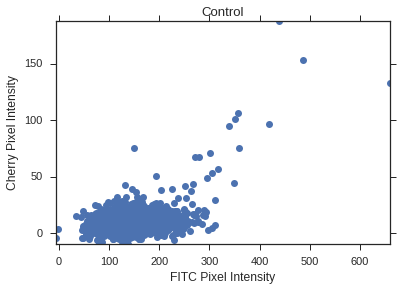

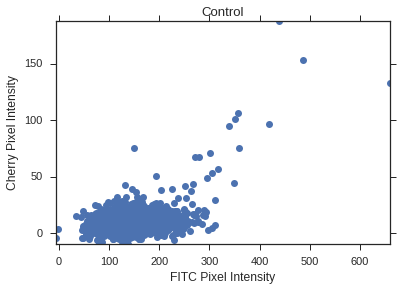

In [6]:
#Plot the data from the control plate
plot_slip_well(mean_FITC_control, mean_cherry_control, well = 'A12', title = 'Control')

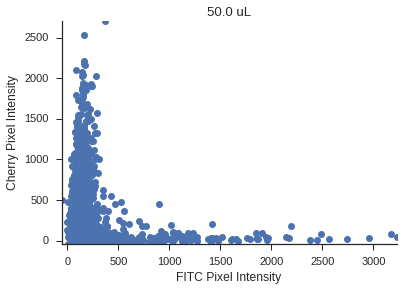

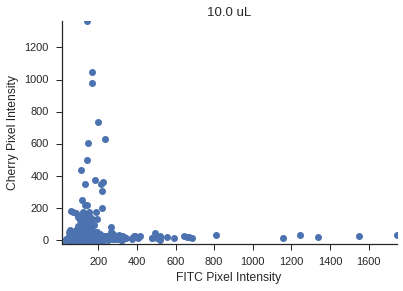

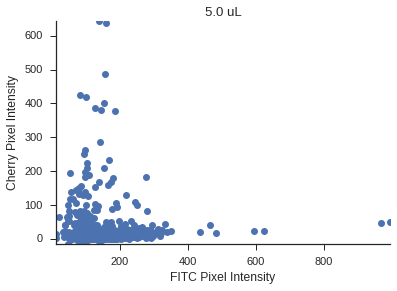

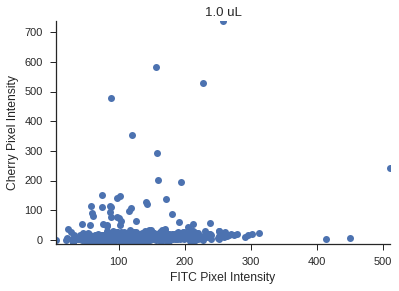

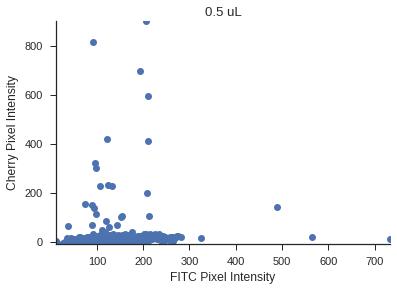

In [7]:
#Plot the scatter plot of intensities with the uninfected cells removed
conc_dict = {}
conc_dict['A5'] = 50 * 5e6
conc_dict['A7'] = 10 * 5e6
conc_dict['A9'] = 5 * 5e6
conc_dict['A10'] = 1 * 5e6
conc_dict['A11'] = 0.5 * 5e6
conc_dict['A12'] = 0 * 5e6

for well in ['A5', 'A7', 'A9', 'A10', 'A11']:
    plot_slip_well(mean_FITC, mean_cherry, well = well, title = str(conc_dict[well]/5e6) + ' uL')
    sns.despine()

In [8]:
#Print the number of cells in each well
for key in mean_FITC_control.keys():
    print key, len(mean_FITC_control[key])
    
for key in mean_FITC.keys():
    print key, len(mean_FITC[key])

A12 1456
A9 1633
A5 3075
A11 1123
A10 1584
A7 579


In [9]:
# Fit a KDE estimator to the no infection control
kernel = fit_kde(mean_FITC_control, mean_cherry_control, 'A12')

In [10]:
# Compute the probability of observing each data point assuming there was no infection
p_values_dict = {}
for well in mean_FITC.keys():
    p_values_dict[well] = np.array(compute_p_values(mean_FITC, mean_cherry, well, kernel))

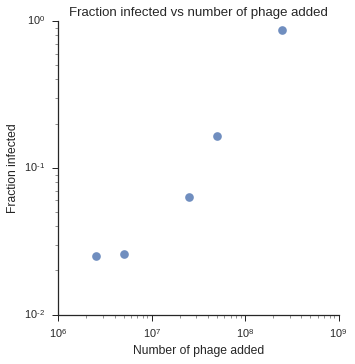

In [12]:
#Compute the fraction infected in each well and plot
conc_list = []
fraction_infected_list = []
for well in p_values_dict.keys():
    p_value = p_values_dict[well]
    fraction_infected = np.float(np.where(p_value < 0.01)[0].shape[0])/np.float(p_value.shape[0])
    conc_list += [conc_dict[well]]
    fraction_infected_list += [fraction_infected]

d = {'Number of phage added': conc_list, 'Fraction infected': fraction_infected_list}
dataframe = pd.DataFrame(data = d)
grid = sns.lmplot('Number of phage added', 'Fraction infected', dataframe, fit_reg = False, scatter_kws={"s": 75})
ax = grid.axes[0][0]
ax.set_title('Fraction infected vs number of phage added')
ax.set_xscale('log')
ax.set_yscale('log')


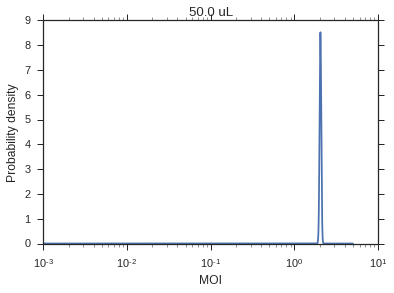

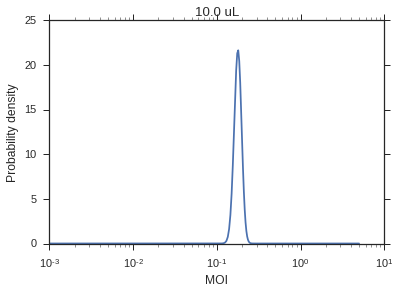

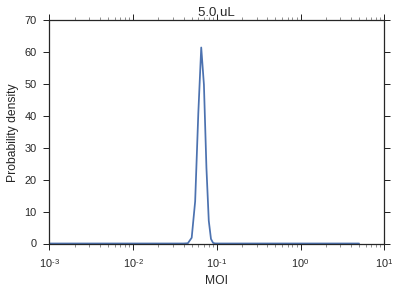

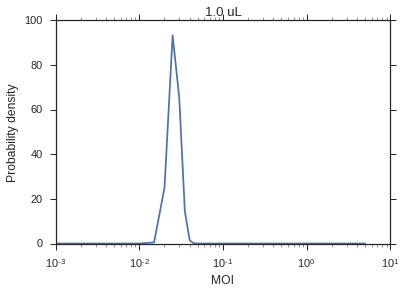

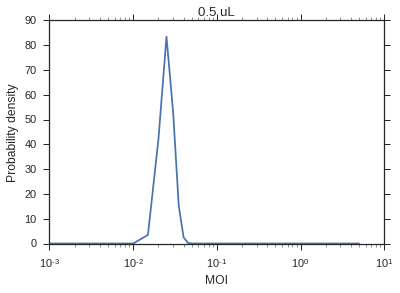

In [13]:
def compute_inverse_MOI_posterior(N_infected, N_cells):
    x = np.linspace(0,5,1000)
    gamma = np.float(N_cells)*np.log(1-1/np.float(N_cells))
    posterior = np.abs(gamma*np.exp(gamma*x))*scipy.stats.beta.pdf(np.exp(gamma*x), 1+N_cells-N_infected, 1+N_infected)

    return x, posterior

for well in ['A5', 'A7', 'A9', 'A10', 'A11']:
    p_value = p_values_dict[well]
    infected_cells = np.where(p_value < 0.01)[0]
    x, posterior = compute_inverse_MOI_posterior(infected_cells.shape[0], p_value.shape[0])
    
    fig = plt.figure()
    ax = plt.gca()
    plt.plot(x, posterior)
    plt.title(str(conc_dict[well]/5e6) + ' uL')
    plt.xlabel('MOI')
    plt.ylabel('Probability density')
    ax.set_xscale('log')
    
    




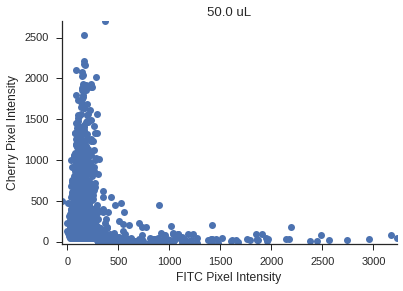

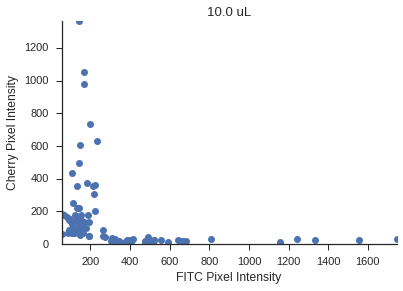

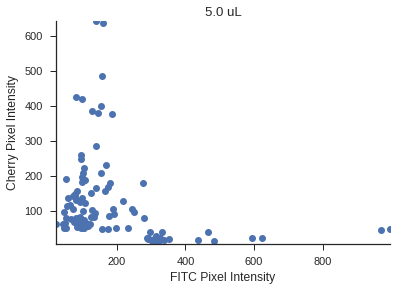

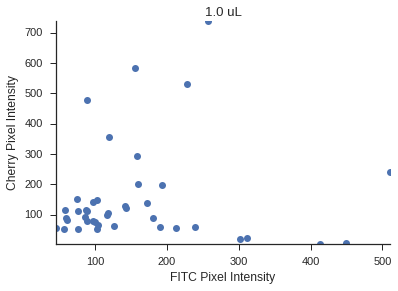

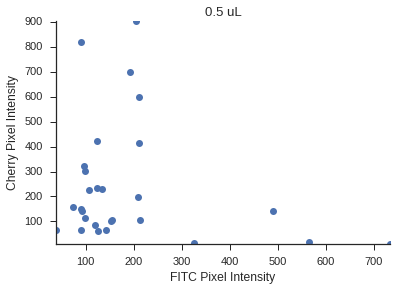

In [14]:
#Plot the scatter plot of intensities with the uninfected cells removed
for well in ['A5', 'A7', 'A9', 'A10', 'A11']:
    p_value = p_values_dict[well]
    infected_cells = np.where(p_value < 0.01)[0]
    plot_slip_well(mean_FITC, mean_cherry, infected_cells = infected_cells, well = well, title = str(conc_dict[well]/5e6) + ' uL')
    sns.despine()

0.0638739112401 154 2411
0.342857142857 48 140
0.364312267658 98 269
0.294964028777 41 139
0.333333333333 35 105


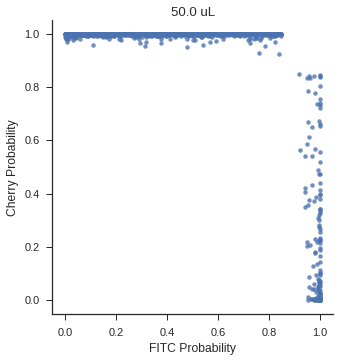

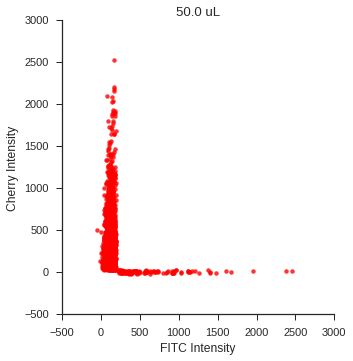

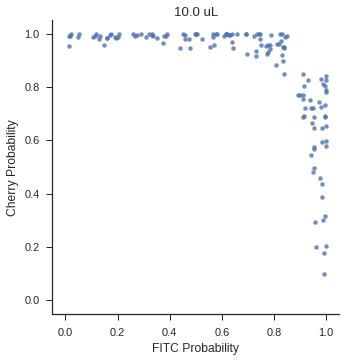

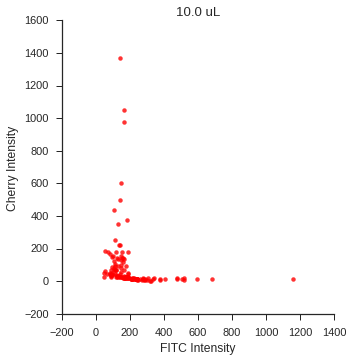

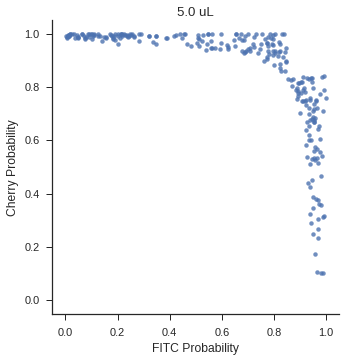

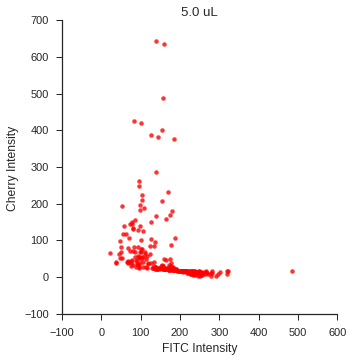

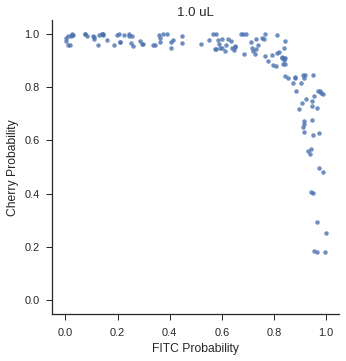

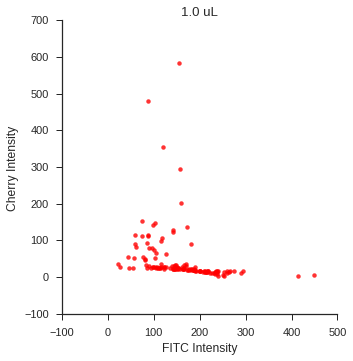

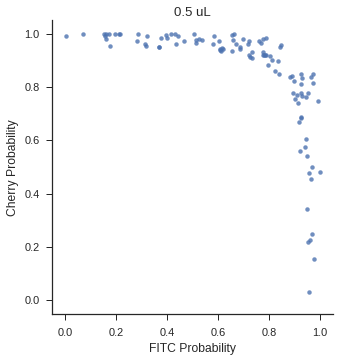

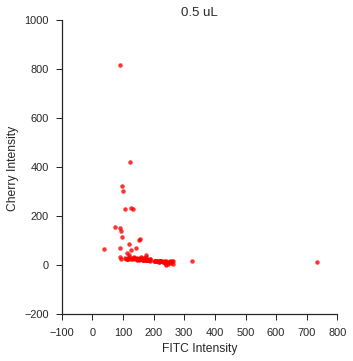

In [15]:
# Use the no phage control to construct a lysis/lysogeny classifier
fitc_control_array = np.array(mean_FITC_control['A12'])
cherry_control_array = np.array(mean_cherry_control['A12'])
kernel_fitc = scipy.stats.gaussian_kde(fitc_control_array)
kernel_cherry = scipy.stats.gaussian_kde(cherry_control_array)

for well in ['A5', 'A7', 'A9', 'A10', 'A11']:
    p_value = p_values_dict[well]
    infected_cells = np.where(p_value < 0.05)[0]
    fitc_list = np.array(mean_FITC[well])[infected_cells]
    cherry_list = np.array(mean_cherry[well])[infected_cells]

    p_fitc = []
    p_cherry = []
    for fitc, cherry in zip(fitc_list, cherry_list):
        p_fitc += [1-kernel_fitc.integrate_box_1d(fitc, 1e6)]
        p_cherry += [1-kernel_cherry.integrate_box_1d(cherry, 1e6)]
        
    # Remove double positives
    p_fitc_new = []
    p_cherry_new = []
    fitc_list_new = []
    cherry_list_new = []
    for p_f, p_c, f, c in zip(p_fitc, p_cherry, fitc_list, cherry_list):
        if p_f < 0.85 or p_c < 0.85:
            p_fitc_new += [p_f]
            p_cherry_new += [p_c]
            fitc_list_new += [f]
            cherry_list_new += [c]
            
    p_fitc = p_fitc_new
    p_cherry = p_cherry_new
    fitc_list = fitc_list_new
    cherry_list = cherry_list_new
    
    d = {'FITC Probability': p_fitc, 'Cherry Probability': p_cherry}
    dataframe = pd.DataFrame(data = d)
    grid = sns.lmplot('FITC Probability', 'Cherry Probability', dataframe, fit_reg = False)
    ax = grid.axes[0][0]
    ax.set_title(str(conc_dict[well]/5e6) + ' uL')
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])

    d = {'FITC Intensity': fitc_list, 'Cherry Intensity': cherry_list}
    dataframe = pd.DataFrame(data = d)
    grid = sns.lmplot('FITC Intensity', 'Cherry Intensity', dataframe, fit_reg = False, scatter_kws = {'color': 'red'})
    ax = grid.axes[0][0]
    ax.set_title(str(conc_dict[well]/5e6) + ' uL')
    
    counter = 0
    for p_f, p_c in zip(p_fitc, p_cherry):
        if p_f > p_c:
            counter += 1
    print np.float(counter)/len(p_fitc), counter, len(p_fitc)
    

    